In [1]:
import numpy as np
try:
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    print("Could not find OMPL")
    raise ImportError("Run inside docker!!")
import matplotlib.pyplot as plt 

## Global Path Planning using RRT* (OMPL Implementation)

In [2]:
from plan_dubins import plan_dubins_path
from plan_rrtstar import plan_rrt_star, plot_circle

map_bound = (10,10)
obs_list = [(4,0), (8,5), (6,9), (2, -4), (8,-5), (6,-9), (5, -6)]

start = [0.0, 0.0, 0.0]
goal = [6.5,-7.5, 0.0]
obs_r = 0.5
robot_r = 0.5
plan_time = 1
path, path_interp, status = plan_rrt_star(start, goal, obs_list, obs_r, robot_r, map_bound, plan_time)
   

Debug:   RRTstar: Planner range detected to be 5.656854
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 11.51 in 12 iterations (13 vertices in the graph)
Found solution
Info:    RRTstar: Created 5649 new states. Checked 1540514 rewire options. 2 goal states in tree. Final solution cost 10.098
Info:    Solution found in 1.008404 seconds


## Dubins path generation using waypoints from RRT*

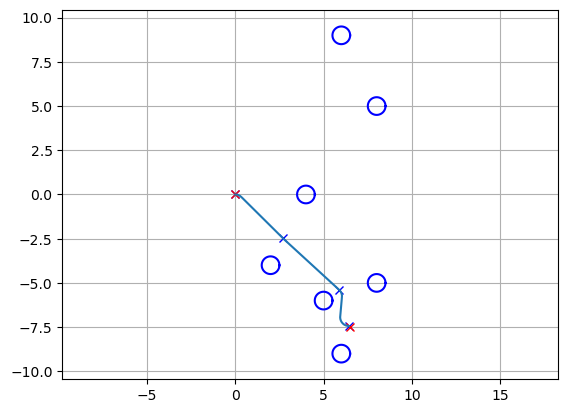

In [3]:
r = 2
v = 1
dt = 0.1

traj_x_dubins = np.array([])
traj_y_dubins = np.array([])
traj_theta_dubins = np.array([])



for i in range(len(path)-1):
    # First Leg
    if i == 0:
        last_yaw = start[2]
        next_yaw = np.arctan2(path[i+1][1] - path[i][1], path[i+1][0] - path[i][0])
    # Last Leg
    elif i == len(path)-2:
        last_yaw = path_theta[-1]
        next_yaw = goal[2]

    # Intermediate Leg
    else:
        last_yaw = path_theta[-1]
        next_yaw = np.arctan2(path[i+1][1] - path[i][1], path[i+1][0] - path[i][0])
    
    path_x, path_y, path_theta, _, _ = plan_dubins_path(path[i][0], path[i][1], last_yaw, path[i+1][0], path[i+1][1], next_yaw, r,
                    step_size=v*dt)    
    
    traj_x_dubins = np.concatenate((traj_x_dubins,path_x))
    traj_y_dubins = np.concatenate((traj_y_dubins,path_y))
    traj_theta_dubins = np.concatenate((traj_theta_dubins,path_theta))

traj_vx_dubins = [0.0]
traj_vy_dubins = [0.0]
traj_omega_dubins = [0.0]
traj_time = [0.0]
time = 0
for i in range(traj_x_dubins.shape[0]-1):
    vx = (traj_x_dubins[i+1] - traj_x_dubins[i])/dt
    vy= (traj_y_dubins[i+1] - traj_y_dubins[i])/dt
    omega = (traj_theta_dubins[i+1] - traj_theta_dubins[i])/dt
    time+=dt
    traj_vx_dubins += [vx]
    traj_vy_dubins += [vy]
    traj_omega_dubins += [omega]
    traj_time  += [time]

traj_time = np.array(traj_time)    
traj_vx_dubins = np.array(traj_vx_dubins)
traj_vy_dubins = np.array(traj_vy_dubins)
traj_omega_dubins = np.array(traj_omega_dubins)

traj_dubins = {
    't': traj_time,
    'x': traj_x_dubins,
    'y': traj_y_dubins,
    'theta': traj_theta_dubins,
    'vx': traj_vx_dubins,
    'vy': traj_vy_dubins,
    'omega': traj_omega_dubins,
    }

for (ox, oy) in obs_list:
    plot_circle(ox, oy, obs_r)

for p in path:
    plt.plot(p[0], p[1], "xb")

plt.plot(start[0], start[1], "xr")
plt.plot(goal[0], goal[1], "xr")
plt.axis("equal")
plt.grid()
plt.plot(traj_dubins['x'], traj_dubins['y'])

## Minimum Jerk Trajectory generated using Boundary Conditions obtained from Dubins

(209,)


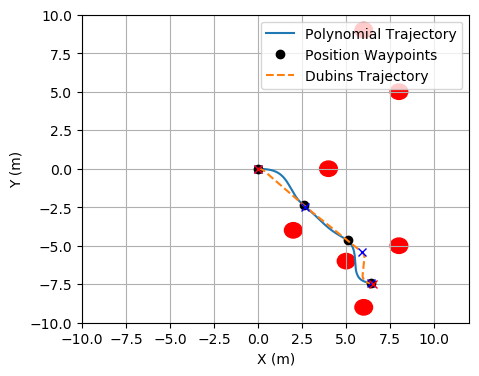

In [4]:
import minsnap_trajectories as ms
from plan_poly import plan_poly_traj

num_points = 3
boundary_cdn = []
idx = 0
for i in range(num_points):
    wp = ms.Waypoint(
        time=traj_dubins['t'][idx],
        position=np.array([traj_dubins['x'][idx], traj_dubins['y'][idx]]),
        velocity=np.array([traj_dubins['vx'][idx+1], traj_dubins['vy'][idx+1]]),
    )
    boundary_cdn.append(wp)
    idx = int(idx + traj_dubins['t'].shape[0]/num_points)

idx = int(traj_dubins['t'].shape[0]-1)
goal_wp = ms.Waypoint(
        time=traj_dubins['t'][idx],
        position=np.array([traj_dubins['x'][idx], traj_dubins['y'][idx]]),
        velocity=np.array([traj_dubins['vx'][idx-1],traj_dubins['vy'][idx-1]]),
)
boundary_cdn.append(goal_wp)  

position, velocity = plan_poly_traj(boundary_cdn,traj_dubins['t'][idx], dt)
traj_x_poly = position[:, 0]
traj_y_poly = position[:, 1]

traj_theta_poly = np.arctan2(
                velocity[:, 1], velocity[:, 0]
            )
print(traj_theta_poly.shape)

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(traj_x_poly, traj_y_poly, label="Polynomial Trajectory")

position_waypoints = np.array([it.position for it in boundary_cdn])
ax.plot(
    position_waypoints[:, 0],
    position_waypoints[:, 1],
    "ko",
    label="Position Waypoints",
)

ax.plot(traj_x_dubins, traj_y_dubins,'--', label="Dubins Trajectory")

for (ox, oy) in obs_list:
    circle = plt.Circle((ox, oy), 0.5, color='r')
    ax.add_patch(circle)
for p in path:
    ax.plot(p[0], p[1], "xb")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_xlim([-10, 12])
ax.set_ylim([-10, 10])
ax.legend(loc="upper right")

ax.plot(start[0], start[1], "xr")
ax.plot(goal[0], goal[1], "xr")
ax.grid()


## MPC CBF on Unicycle System with Dubins Trajectory

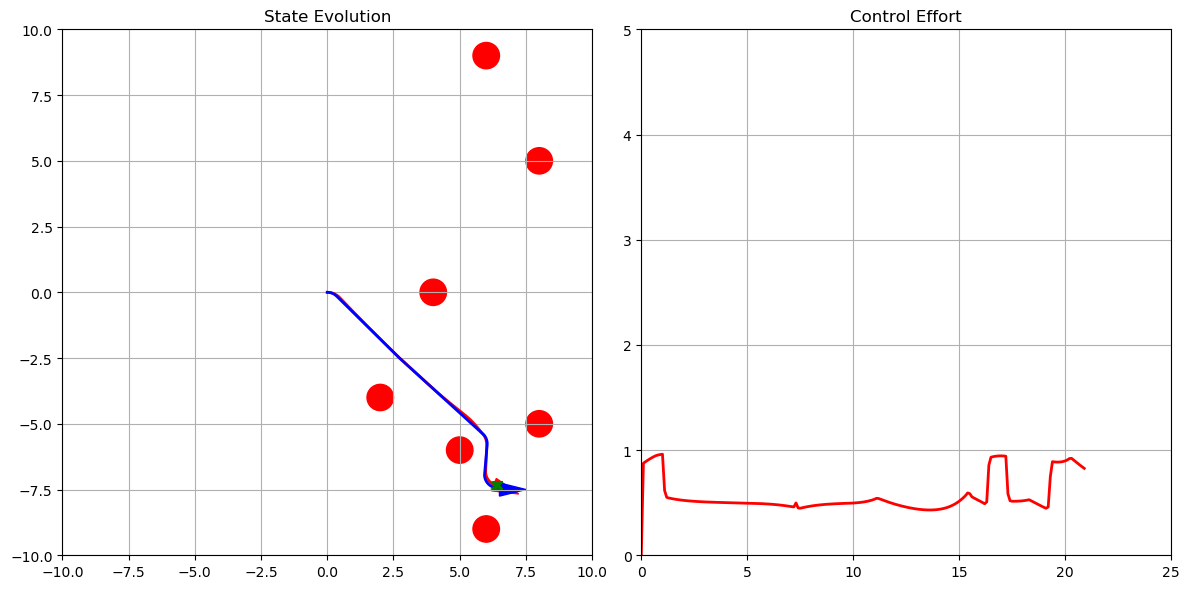

In [5]:
import casadi
from plan_mpc_unicycle import MPC_CBF_Unicycle, dm_to_array
from anim_utils import simulate
from IPython.display import HTML

Q_x = 1
Q_y = 1
Q_theta = 1
R_v = 1
R_omega = 0.005

dt = 0.1
N = 50
idx = 0
t0 = 0


ref_states = np.array([traj_x_dubins.tolist(), traj_y_dubins.tolist(), traj_theta_dubins.tolist()]).T
v_lim = [-1.2, 1.2]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]
mpc_cbf = MPC_CBF_Unicycle(dt, N, v_lim, omega_lim, Q, R, obstacles= obs_list, cbf_const=True, alpha=0.04)

state_0 = casadi.DM([start[0], start[1], start[2]])
u0 = casadi.DM.zeros((mpc_cbf.n_controls, N))
X0 = casadi.repmat(state_0, 1, N + 1)
cat_states = dm_to_array(X0)
cat_controls = dm_to_array(u0[:, 0])

x_arr = [start[0]]
y_arr = [start[0]]
for i in range(len(ref_states)+10):    
    u, X_pred = mpc_cbf.solve(X0, u0, ref_states, i)

    cat_states = np.dstack((cat_states, dm_to_array(X_pred)))
    cat_controls = np.dstack((cat_controls, dm_to_array(u[:, 0])))
    
    t0, X0, u0 = mpc_cbf.shift_timestep(dt, t0, X_pred, u)
    
    x_arr.append(X0[0,1])
    y_arr.append(X0[1,1])
    idx += 1

num_frames = len(ref_states)
sim = simulate(ref_states, cat_states, cat_controls, obs_list, num_frames, dt, N,
                np.array([start[0], start[1], start[2], goal[0], goal[1], goal[2]]),
                x_lim= [-10, 10], y_lim= [-10,10]
            )

HTML(sim.to_html5_video())

## MPC CBF on Unicycle System with Minimum Jerk Trajectory

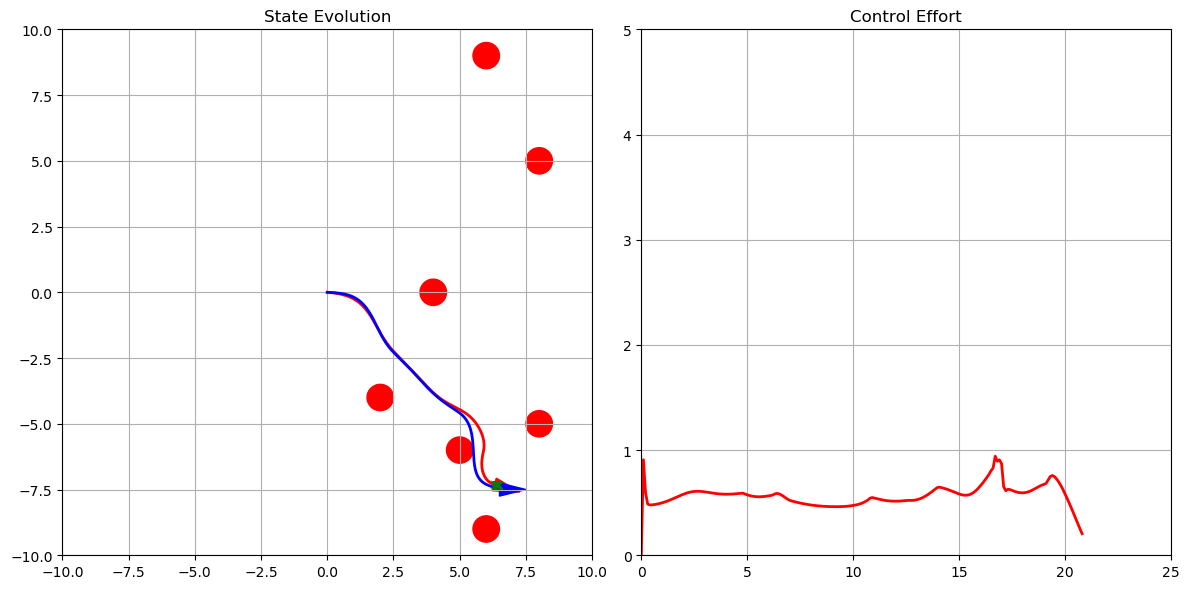

In [7]:
import casadi
from plan_mpc_unicycle import MPC_CBF_Unicycle, dm_to_array
from anim_utils import simulate
from IPython.display import HTML

Q_x = 1
Q_y = 1
Q_theta = 1
R_v = 1
R_omega = 0.005

dt = 0.1
N = 50
idx = 0
t0 = 0


ref_states = np.array([traj_x_poly.tolist(), traj_y_poly.tolist(), traj_theta_poly.tolist()]).T
v_lim = [-1.2, 1.2]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]
mpc_cbf = MPC_CBF_Unicycle(dt, N, v_lim, omega_lim, Q, R, obstacles= obs_list, cbf_const=True, alpha=0.04)

state_0 = casadi.DM([start[0], start[1], start[2]])
u0 = casadi.DM.zeros((mpc_cbf.n_controls, N))
X0 = casadi.repmat(state_0, 1, N + 1)
cat_states = dm_to_array(X0)
cat_controls = dm_to_array(u0[:, 0])

x_arr = [start[0]]
y_arr = [start[0]]
for i in range(len(ref_states)+10):    
    u, X_pred = mpc_cbf.solve(X0, u0, ref_states, i)

    cat_states = np.dstack((cat_states, dm_to_array(X_pred)))
    cat_controls = np.dstack((cat_controls, dm_to_array(u[:, 0])))
    
    t0, X0, u0 = mpc_cbf.shift_timestep(dt, t0, X_pred, u)
    
    x_arr.append(X0[0,1])
    y_arr.append(X0[1,1])
    idx += 1

num_frames = len(ref_states)
sim = simulate(ref_states, cat_states, cat_controls, obs_list, num_frames, dt, N,
                np.array([start[0], start[1], start[2], goal[0], goal[1], goal[2]]),
                x_lim= [-10, 10], y_lim= [-10,10]
            )

HTML(sim.to_html5_video())